<a href="https://colab.research.google.com/github/Mina-Moeini/Brain-segmentation-in-preterm-infants-with-MRI-images/blob/main/Brain_MRI_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import cv2

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


**I cropped T2 images and their related masks with 3D slicer and save them as ".nii.gz" format.
Now I wanna plot one of them for testing:**

<Figure size 1200x600 with 0 Axes>

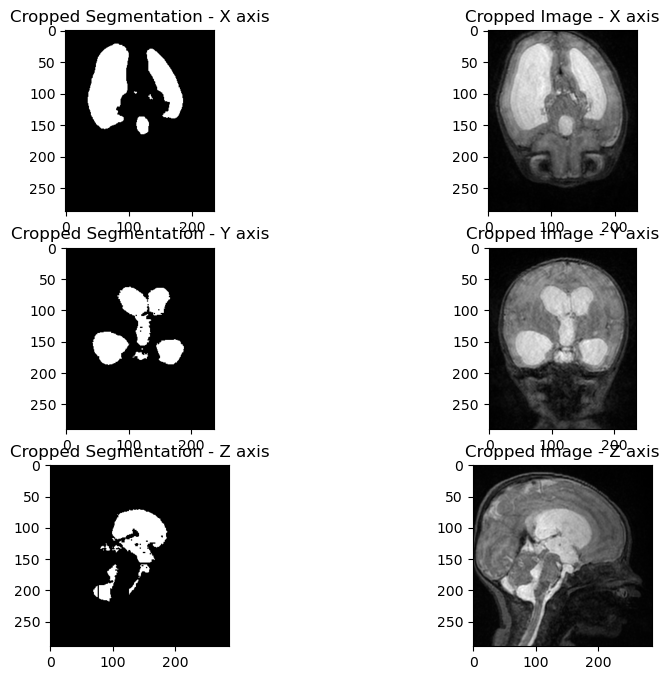

In [ ]:
def plot_mri_with_segmentation(mri_path, segmentation_path):
    # Load MRI image and segmentation using nibabel
    mri_img = nib.load(mri_path)
    segmentation_img = nib.load(segmentation_path)

    # Get the image data as NumPy arrays
    mri_array = mri_img.get_fdata()
    segmentation_array = segmentation_img.get_fdata()

    # Plotting the MRI image
    plt.figure(figsize=(12, 6))

    # Display the original and cropped images side by side using matplotlib
    fig, axes = plt.subplots(3, 2, figsize=(10, 8))

    # Rotate the images for correct orientation display(just for z axis)
    mri_array = np.rot90(mri_array, k=1, axes=(1, 0))
    segmentation_array = np.rot90(segmentation_array, k=1, axes=(1, 0))

    # Display the cropped image
    axes[0][0].imshow(segmentation_array[segmentation_array.shape[0] // 2, :,: ], cmap='gray')
    axes[0][0].set_title('Cropped Segmentation - X axis')

    axes[0][1].imshow(mri_array[mri_array.shape[0] // 2, :,: ], cmap='gray')
    axes[0][1].set_title('Cropped Image - X axis')

    axes[1][0].imshow(segmentation_array[:,segmentation_array.shape[1] // 2,: ], cmap='gray')
    axes[1][0].set_title('Cropped Segmentation - Y axis')

    axes[1][1].imshow(mri_array[: , mri_array.shape[1]//2 ,:] , cmap='gray')
    axes[1][1].set_title('Cropped Image - Y axis')

    # Display the cropped image
    axes[2][0].imshow(segmentation_array[:,:, segmentation_array.shape[2] //2 ], cmap='gray')
    axes[2][0].set_title('Cropped Segmentation - Z axis')

    axes[2][1].imshow(mri_array[:,: , mri_array.shape[2] //2  ], cmap='gray')
    axes[2][1].set_title('Cropped Image - Z axis')

    plt.show()
# Specify the path to one MRI image and its segmentation

mri_path = r"C:\Users\Asus\Desktop\Data\cropped\8005195321_2014_12_04_T2 cropped.nii.gz"
segmentation_path = r"C:\Users\Asus\Desktop\Data\cropped\8005195321_2014_12_04_Segmentation-label cropped.nii.gz"

# Call the function to plot the MRI image with segmentation
plot_mri_with_segmentation(mri_path, segmentation_path)


## Load dataset

In [ ]:
data_folder = 'C:/Users/Asus/Desktop/Data/cropped'

# List all files in the data folder with a .nii extension
nii_files = [file for file in os.listdir(data_folder) if file.endswith('.nii.gz')]

raw_data = []
labeled_data = []

for file in nii_files:
    file_path = os.path.join(data_folder, file)
    img = nib.load(file_path)
    data = img.get_fdata()

    # Check if the file is a raw data file
    if 'Segmentation-label' in file:
        labeled_data.append(data)
        print(f"Loaded labeled file: {file}, Data Shape: {data.shape}")
    else:
        raw_data.append(data)
        print(f"Loaded raw file: {file}, Data Shape: {data.shape}")

# Print the shapes of the loaded data
print("Raw Data Shapes:", [data.shape for data in raw_data])
print("Labeled Data Shapes:", [data.shape for data in labeled_data])

Loaded labeled file: 8005195321_2014_12_04_Segmentation-label cropped.nii.gz, Data Shape: (287, 290, 236)
Loaded raw file: 8005195321_2014_12_04_T2 cropped.nii.gz, Data Shape: (287, 290, 236)
Loaded labeled file: 8005881757_2015_03_13_Segmentation-label cropped.nii.gz, Data Shape: (212, 248, 169)
Loaded raw file: 8005881757_2015_03_13_T2 cropped.nii.gz, Data Shape: (212, 248, 169)
Loaded labeled file: 8008311939_2016_10_28_Segmentation-label cropped.nii.gz, Data Shape: (244, 264, 212)
Loaded raw file: 8008311939_2016_10_28_T2 cropped.nii.gz, Data Shape: (244, 264, 212)
Loaded raw file: 8009977558_2017_05_05_T2 cropped.nii.gz, Data Shape: (298, 297, 243)
Loaded labeled file: 8009977558_2017_05_05_T2_Segmentation-label cropped.nii.gz, Data Shape: (298, 297, 243)
Loaded raw file: 8010435853_2017_09_21_T2 cropped.nii.gz, Data Shape: (268, 249, 169)
Loaded labeled file: 8010435853_2017_09_21_T2_Segmentation-label cropped.nii.gz, Data Shape: (268, 249, 169)
Loaded labeled file: 8010511691_20

## Resize data

We use cv2.INTER_NEAREST to keep the values of the masks in binary value (0 and 1) after resizing.

In [ ]:
data_folder = 'C:/Users/Asus/Desktop/Data/cropped'
output_folder = 'C:/Users/Asus/Desktop/Data/resized'

# List all files in the data folder with a .nii extension
nii_files = [file for file in os.listdir(data_folder) if file.endswith('.nii.gz')]

for file in nii_files:
    file_path = os.path.join(data_folder, file)
    img = nib.load(file_path)
    data = img.get_fdata()

    # Determine the interpolation method based on filename
    if 'Segmentation-label' in file:
        interpolation_method = cv2.INTER_NEAREST
    else:
        interpolation_method = cv2.INTER_LINEAR

    # Resize the image
    target_shape = (256, 256, 256)
    resized_data = np.zeros(target_shape)

    for i in range(min(data.shape[2], target_shape[2])):
        resized_data[..., i] = cv2.resize(data[..., i], (target_shape[1], target_shape[0]), interpolation=interpolation_method)

    # Save the resized image
    output_path = os.path.join(output_folder, file.replace('.nii', '_resized.nii'))
    nib.save(nib.Nifti1Image(resized_data, img.affine), output_path)

    print(f"Resized and saved file: {file}, Resized Data Shape: {resized_data.shape}")


Resized and saved file: 8005195321_2014_12_04_Segmentation-label cropped.nii.gz, Resized Data Shape: (256, 256, 256)
Resized and saved file: 8005195321_2014_12_04_T2 cropped.nii.gz, Resized Data Shape: (256, 256, 256)
Resized and saved file: 8005881757_2015_03_13_Segmentation-label cropped.nii.gz, Resized Data Shape: (256, 256, 256)
Resized and saved file: 8005881757_2015_03_13_T2 cropped.nii.gz, Resized Data Shape: (256, 256, 256)
Resized and saved file: 8008311939_2016_10_28_Segmentation-label cropped.nii.gz, Resized Data Shape: (256, 256, 256)
Resized and saved file: 8008311939_2016_10_28_T2 cropped.nii.gz, Resized Data Shape: (256, 256, 256)
Resized and saved file: 8009977558_2017_05_05_T2 cropped.nii.gz, Resized Data Shape: (256, 256, 256)
Resized and saved file: 8009977558_2017_05_05_T2_Segmentation-label cropped.nii.gz, Resized Data Shape: (256, 256, 256)
Resized and saved file: 8010435853_2017_09_21_T2 cropped.nii.gz, Resized Data Shape: (256, 256, 256)
Resized and saved file: 

**Test one of the resized image**

<Figure size 1200x600 with 0 Axes>

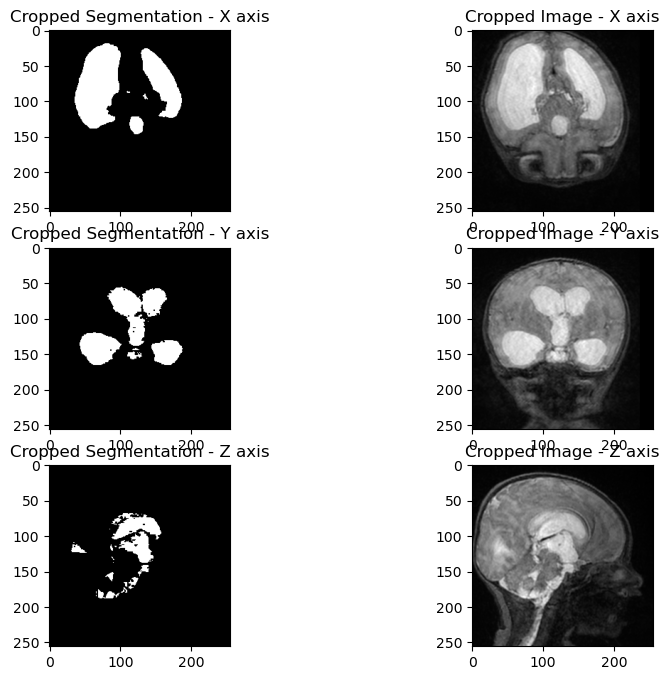

In [ ]:
mri_path = r"C:\Users\Asus\Desktop\Data\resized\8005195321_2014_12_04_T2 cropped_resized.nii.gz"
segmentation_path = r"C:\Users\Asus\Desktop\Data\resized\8005195321_2014_12_04_Segmentation-label cropped_resized.nii.gz"

# Call the function to plot the MRI image with segmentation
plot_mri_with_segmentation(mri_path, segmentation_path)

## Preprocessing


**Normalization/Data augmentation/Convert 3D to 2D**

Convert 3D images and related masks to 2D with the aim of increasing data

In [ ]:
from skimage import io
# Set the paths
data_folder = 'C:/Users/Asus/Desktop/Data/resized'
output_folder = 'C:/Users/Asus/Desktop/Data/2D_slices'


# List all files in the data folder with a .nii.gz extension
nii_files = [file for file in os.listdir(data_folder) if file.endswith('_T2 cropped_resized.nii.gz')]

# Iterate through each file
for file in nii_files:
    file_path = os.path.join(data_folder, file)

    # Load 3D MRI image and corresponding segmentation as NumPy arrays
    img_data = nib.load(file_path).get_fdata()
    seg_file = file.replace("_T2 cropped_resized.nii.gz", "_Segmentation-label cropped_resized.nii.gz")
    seg_path = os.path.join(data_folder, seg_file)
    seg_data = nib.load(seg_path).get_fdata()

    # Iterate through each slice in the 3D volume
    #axial slice
    for slice_idx in range(img_data.shape[0]):
        # Extract 2D slices from both MRI and segmentation
        img_slice = img_data[slice_idx,: , :]
        seg_slice = seg_data[slice_idx, :, :]

        # Normalize to [0, 1] range
        img_slice_normalized = (img_slice - np.min(img_slice)) / (np.max(img_slice) - np.min(img_slice))

        # Save 2D slices

        img_output_path = os.path.join(output_folder, f"{os.path.splitext(file.replace('_T2 cropped_resized.nii.gz', '').replace(' ', '_'))[0]}_{slice_idx}_img.nii.gz")
        seg_output_path = os.path.join(output_folder, f"{os.path.splitext(seg_file.replace('_Segmentation-label cropped_resized.nii.gz', '').replace(' ', '_'))[0]}_{slice_idx}_seg.nii.gz")

        # Create NIfTI images
        img_nifti = nib.Nifti1Image(img_slice_normalized, affine=np.eye(4))
        seg_nifti = nib.Nifti1Image(seg_slice, affine=np.eye(4))

        # Save NIfTI images
        nib.save(img_nifti, img_output_path)
        nib.save(seg_nifti, seg_output_path)

print("Conversion to 2D slices and saving as .nii.gz completed.")



Conversion to 2D slices and saving as .nii.gz completed.


After this code I got 5,120 2d images

# U-Net model:

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def unet_model(input_shape=(256, 256, 1)):
    # Input layer
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Expansive Path
    up5 = UpSampling2D(size=(2, 2))(conv4)
    merge5 = Concatenate(axis=-1)([conv3, up5])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    merge6 = Concatenate(axis=-1)([conv2, up6])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = Concatenate(axis=-1)([conv1, up7])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    output = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model


#model = unet_model(input_shape=(256, 256, 1))
#model.summary()



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/drive/My Drive/2D_slices' '/content/'
!ls /content/

2D_slices  drive  sample_data


In [ ]:
!ls -1 /content/2D_slices | wc -l

5140


In [ ]:
!ls -l /content/2D_slices


In [ ]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.3 MB/s eta 0:00:00


**Data augmentation**

In [ ]:
import os
import numpy as np
import nibabel as nib
from skimage import io
from monai.transforms import *

# Set the paths
data_folder = '/content/2D_slices'
output_folder = '/content/augmented'

# Create the augmented folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# List all files in the data folder with a _T2 cropped_resized.nii.gz extension
image_files = [file for file in os.listdir(data_folder) if file.endswith('_img.nii.gz')]
seg_files = [file.replace('_img.nii.gz', '_seg.nii.gz') for file in image_files]

# Define MONAI transforms for preprocessing
geometric_transforms = Compose([
    RandRotate(range_x=15, prob=0.5),
    RandFlip(spatial_axis=0, prob=0.5),
])

intensity_transforms = Compose([
    RandAdjustContrast(prob=0.5),
    RandGaussianNoise(prob=0.5),
    RandGaussianSmooth(prob=0.5),
])

# Iterate through each file
for img_file, seg_file in zip(image_files, seg_files):
    img_path = os.path.join(data_folder, img_file)
    seg_path = os.path.join(data_folder, seg_file)

    # Load 2D image and segmentation
    img_data = nib.load(img_path).get_fdata()
    img_data = np.expand_dims(img_data, axis=-1)  # Add a third dimension
    seg_data = nib.load(seg_path).get_fdata()
    seg_data = np.expand_dims(seg_data, axis=-1)

    #print(f"Original Image Shape: {img_data.shape}")
    #print(f"Original Segmentation Shape: {seg_data.shape}")

    # Create a loop to generate multiple augmented images
    #we have augmentation for each img
    for i in range(2):  # the number of augmented images
        if i == 0:  # For the first iteration, no transformations are applied
            transformed_img = np.copy(img_data)
            transformed_seg = np.copy(seg_data)
        else:

            # Make a copy of the original data to avoid modifying
            augmented_img_data = np.copy(img_data)
            augmented_seg_data = np.copy(seg_data)

            # ensure that the same transformation is applied to both the image and segmentation
            # Combine image and segmentation along the third dimension
            combined_data = np.concatenate([augmented_img_data, augmented_seg_data], axis=-1)

            # Apply geometric transforms to both image and segmentation
            transformed_data = geometric_transforms(combined_data)

            # Separate the transformed data back into image and segmentation
            transformed_img = transformed_data[..., 0]
            transformed_seg = transformed_data[..., 1]

            # Apply intensity transforms to the image only
            transformed_img = intensity_transforms(transformed_img)
            # Convert the PyTorch tensor to NumPy array
            transformed_img = transformed_img.numpy()
            transformed_seg = transformed_seg.numpy()



        #print(f"Transformed Image Shape: {transformed_img.shape}")
        #print(f"Transformed Segmentation Shape: {transformed_seg.shape}")

        # Save the MRI and segmentation slices
        img_output_path = os.path.join(output_folder, f"{img_file.replace('_img.nii.gz', f'_{i}_img.nii.gz')}")
        seg_output_path = os.path.join(output_folder, f"{seg_file.replace('_seg.nii.gz', f'_{i}_seg.nii.gz')}")

        # Save the transformed slices back in NIfTI format
        nib.save(nib.Nifti1Image(transformed_img, affine=np.eye(4)), img_output_path)
        nib.save(nib.Nifti1Image(transformed_seg, affine=np.eye(4)), seg_output_path)

print("Data augmentation and saving completed")


Data augmentation and saving completed


In [ ]:
!ls -1 /content/augmented/ | wc -l

10240


In [ ]:
!ls -l /content/augmented


In [ ]:
import glob
import os

folder_path = '/content/augmented/'

# Get a list of all files in the folder
files_to_delete = glob.glob(os.path.join(folder_path, '*'))

# Delete the files
for file_path in files_to_delete:
    os.remove(file_path)

In [ ]:
!ls -l /content/2D_augmented/


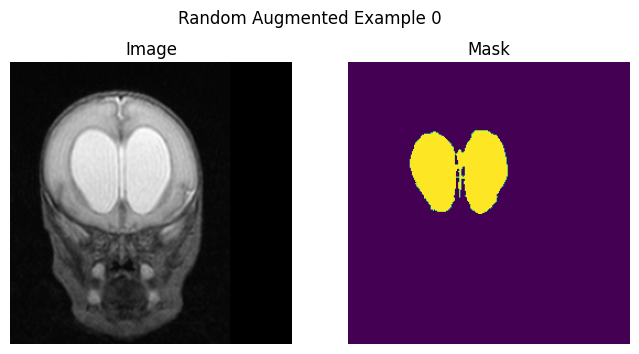

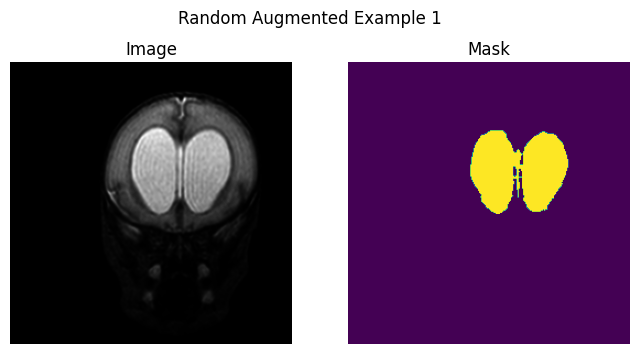

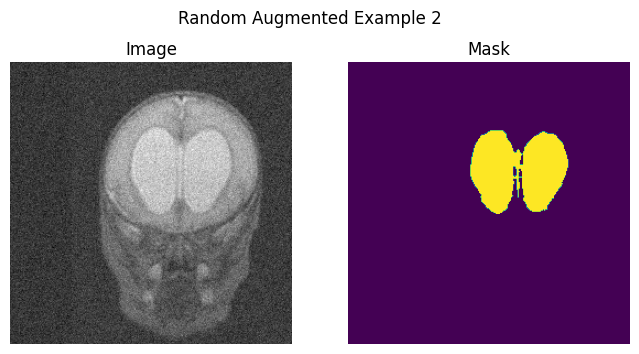

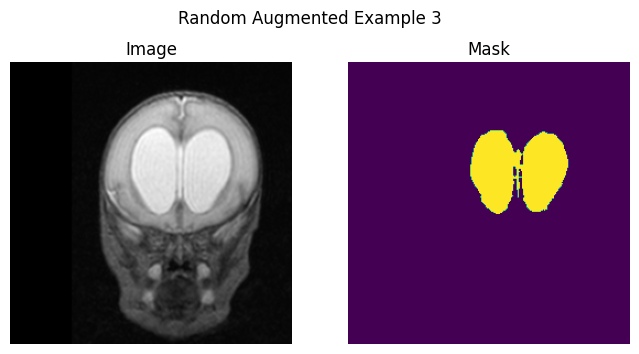

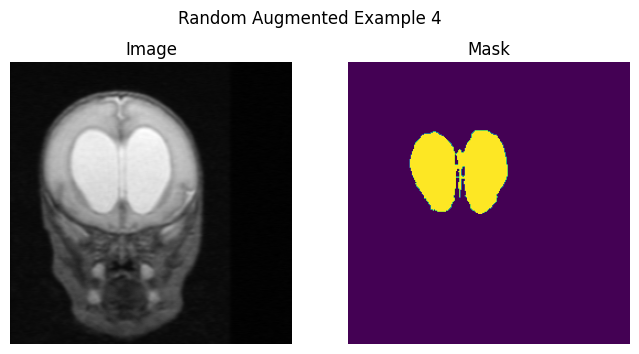

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Function to display an image with its mask
def show_image_with_mask(image, mask, title):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(image, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Image')

    ax[1].imshow(mask, cmap='viridis')  # Adjust the colormap as needed
    ax[1].axis('off')
    ax[1].set_title('Mask')

    plt.suptitle(title)
    plt.show()

import random

# Load and display a random augmented image with its mask
random_index = random.randint(0, len(image_files) - 1)
img_file = image_files[random_index]
seg_file = seg_files[random_index]

for i in range(5):  # Display 5 examples
    # Load the augmented image and mask
    img_path = os.path.join(output_folder, f"{img_file.replace('_img.nii.gz', f'_{i}_img.nii.gz')}")
    seg_path = os.path.join(output_folder, f"{seg_file.replace('_seg.nii.gz', f'_{i}_seg.nii.gz')}")

    augmented_img = nib.load(img_path).get_fdata()
    augmented_mask = nib.load(seg_path).get_fdata()

    # Display the image with its mask
    show_image_with_mask(augmented_img, augmented_mask, f"Random Augmented Example {i}")


In [ ]:
from sklearn.model_selection import train_test_split
import os
import nibabel as nib
import numpy as np
import pandas as pd

# Set the path
data_folder = '/content/augmented'

# List all files in the data folder
img_files = [file for file in os.listdir(data_folder) if file.endswith('_img.nii.gz')]

#we can find patient ids from filename
patient_ids = list(set([file.split('_')[0] for file in img_files]))
print("Patient ID:",patient_ids)

# Split patients into train, validation, and test sets
train_patients, test_patients = train_test_split(patient_ids, test_size=0.2, random_state=42)
train_patients, val_patients = train_test_split(train_patients, test_size=0.1, random_state=42)
print("Train patients:",train_patients)
print("Test patients:",test_patients)
print("Val patients:",val_patients)

# Create file lists for each set
train_files = [file for file in img_files if file.split('_')[0] in train_patients]
val_files = [file for file in img_files if file.split('_')[0] in val_patients]
test_files = [file for file in img_files if file.split('_')[0] in test_patients]

# Define a function to load and preprocess the data
def load_data(file_paths):
    images = []
    masks = []

    for file in file_paths:
        img_path = os.path.join(data_folder, file)
        seg_path = os.path.join(data_folder, file.replace('_img.nii.gz', '_seg.nii.gz'))

        # Check if the segmentation file exists
        if not os.path.exists(seg_path):
            print(f"Segmentation file not found for {file}")
            continue

        # Load 2D MRI image and corresponding segmentation mask as NumPy arrays
        img_data = nib.load(img_path).get_fdata()
        seg_data = nib.load(seg_path).get_fdata()

        # Normalize to [0, 1] range
        # img_data_normalized = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))

        images.append(img_data)
        masks.append(seg_data)

    return np.array(images), np.array(masks)

# Load training data
X_train, y_train = load_data(train_files)

# Load validation data
X_val, y_val = load_data(val_files)

# Load testing data
X_test, y_test = load_data(test_files)

# Print the resulting file lists
print("Train Files:", train_files)
print("Validation Files:", val_files)
print("Test Files:", test_files)

# Print the shapes of the data arrays
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)

# Print the resulting file lists in a sorted table
train_file_table = pd.DataFrame({"Train Files": sorted(train_files)})
val_file_table = pd.DataFrame({"Validation Files": sorted(val_files)})
test_file_table = pd.DataFrame({"Test Files": sorted(test_files)})

# Display the tables
print("\nTrain Files:")
print(train_file_table)
print("\nValidation Files:")
print(val_file_table)
print("\nTest Files:")
print(test_file_table)


Patient ID: ['8008311939', '8010435853', '8005881757', '8014228907', '8009977558', '8005195321', '8010511691', '8011228112', '8010969790', '8010761051']
Train patients: ['8009977558', '8005195321', '8010511691', '8011228112', '8010761051', '8005881757', '8014228907']
Test patients: ['8010969790', '8010435853']
Val patients: ['8008311939']


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
# Instantiate the model
model = unet_model(input_shape=(256, 256, 1))
optimizer = Adam(learning_rate=0.0001)
# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Set up a checkpoint to save the best model during training
checkpoint = ModelCheckpoint('unet_model_final.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=25,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

In [ ]:
predicted_masks = model.predict(X_test)


16/16 [==============================] - 6s 395ms/step


## Evaluation

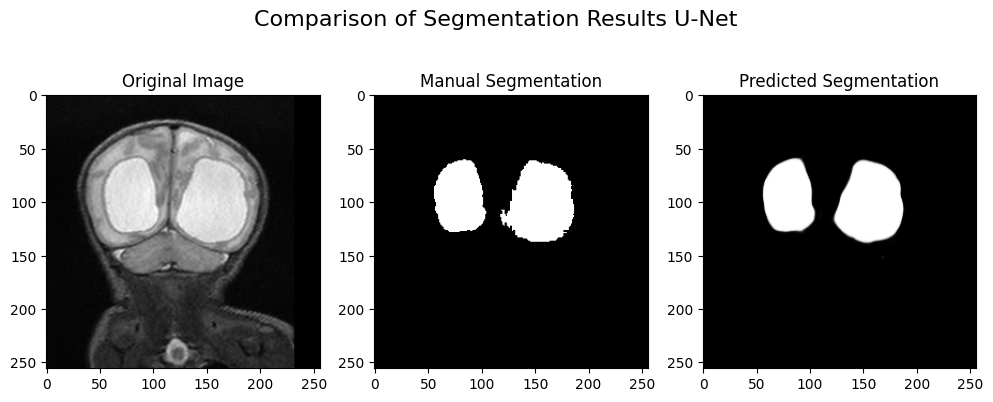

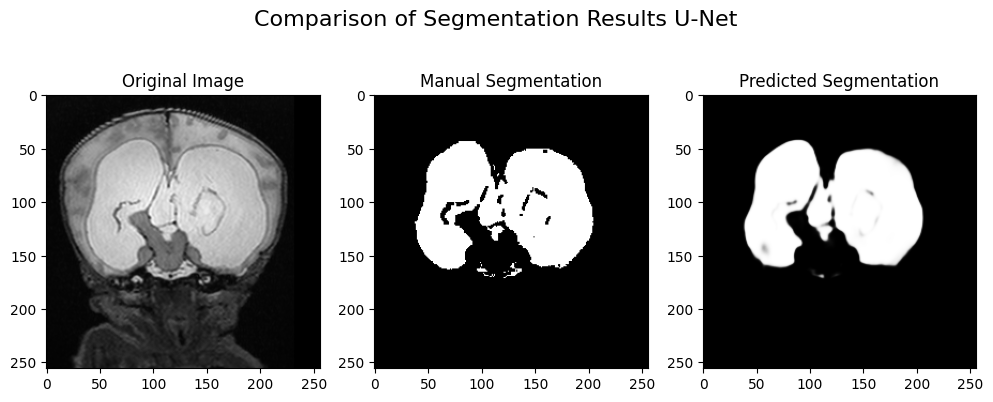

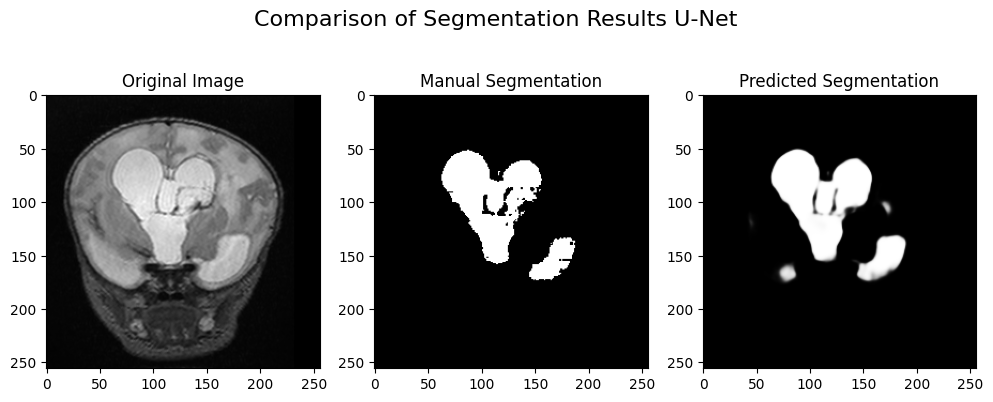

In [ ]:

import matplotlib.pyplot as plt

# Choose a few random indices for visualization
sample_indices = [358, 70, 330]


for idx in sample_indices:
    # Original MRI scan
    original_image = X_test[idx, :, :]

    # Manual segmentation mask
    manual_mask = y_test[idx, :, :]

    # Predicted segmentation mask
    predicted_mask = predicted_masks[idx, :, :]



    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(manual_mask, cmap='gray')
    plt.title('Manual Segmentation')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Segmentation')
    plt.suptitle('Comparison of Segmentation Results U-Net', fontsize=16, y=1.05)
    plt.show()


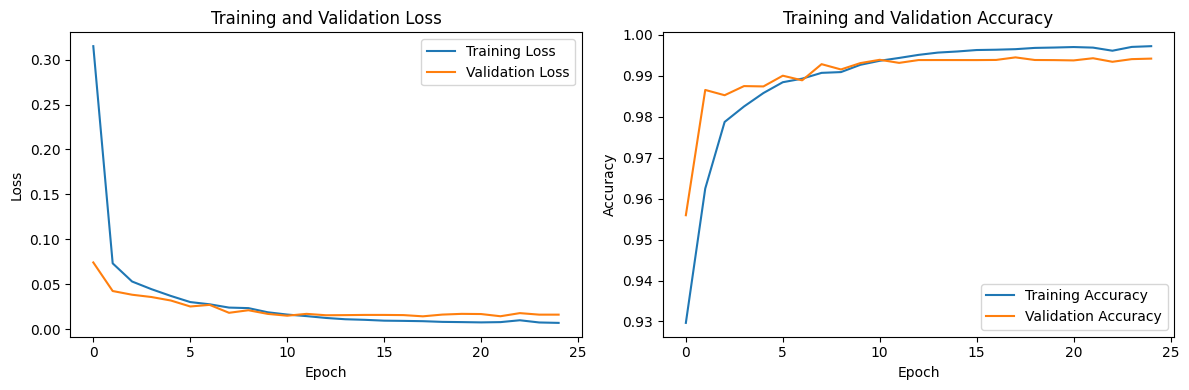

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tabulate import tabulate

# Display a summary of loss value and accuracy at each epoch in a table
table_data = []
for epoch in range(1, 26):
    train_loss = history.history['loss'][epoch - 1]
    train_accuracy = history.history['accuracy'][epoch - 1]
    val_loss = history.history['val_loss'][epoch - 1]
    val_accuracy = history.history['val_accuracy'][epoch - 1]

    table_data.append([epoch, train_loss, train_accuracy, val_loss, val_accuracy])

headers = ["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"]
table = tabulate(table_data, headers, tablefmt="fancy_grid")

print(table)


╒═════════╤══════════════╤══════════════════╤════════════╤════════════════╕
│   Epoch │   Train Loss │   Train Accuracy │   Val Loss │   Val Accuracy │
╞═════════╪══════════════╪══════════════════╪════════════╪════════════════╡
│       1 │   0.315039   │         0.92966  │  0.0742372 │       0.955955 │
├─────────┼──────────────┼──────────────────┼────────────┼────────────────┤
│       2 │   0.0732224  │         0.962479 │  0.0424141 │       0.986555 │
├─────────┼──────────────┼──────────────────┼────────────┼────────────────┤
│       3 │   0.0530111  │         0.978741 │  0.0382906 │       0.985265 │
├─────────┼──────────────┼──────────────────┼────────────┼────────────────┤
│       4 │   0.0444766  │         0.982518 │  0.0357365 │       0.987497 │
├─────────┼──────────────┼──────────────────┼────────────┼────────────────┤
│       5 │   0.036941   │         0.985798 │  0.0318434 │       0.987414 │
├─────────┼──────────────┼──────────────────┼────────────┼────────────────┤
│       6 │ 

In [ ]:
# Display the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 256, 256, 64)         640       ['input_2[0][0]']             
                                                                                                  
 conv2d_16 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_15[0][0]']           
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_16[0][0]']           
 g2D)                                                                                       

In [ ]:
model.save('/content/drive/MyDrive/models/unet_model_final.h5')

16/16 [==============================] - 6s 411ms/step
+------------------+---------+
| Metric           |   Value |
+==================+=========+
| Dice Coefficient |    0.97 |
+------------------+---------+
| Jaccard Index    |    0.95 |
+------------------+---------+
| Sensitivity      |    0.98 |
+------------------+---------+
| Specificity      |    1    |
+------------------+---------+
| Precision        |    0.96 |
+------------------+---------+
| Recall           |    0.98 |
+------------------+---------+


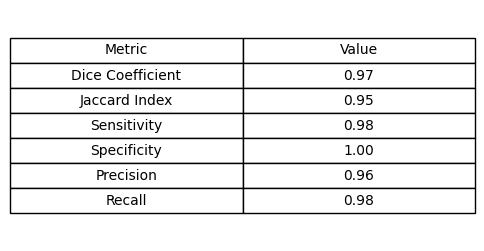

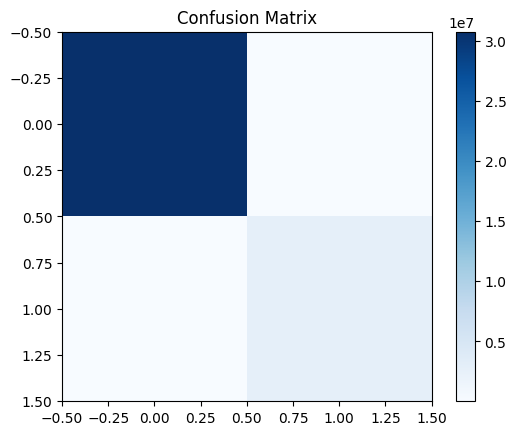

In [ ]:
from tabulate import tabulate
# Load the trained model
loaded_model = load_model('/content/drive/MyDrive/models/unet_model_final.h5')

# Make predictions on the test set
y_pred = loaded_model.predict(X_test)

# Squeeze the singleton dimension
y_pred = np.squeeze(y_pred, axis=-1)

# Define functions for evaluation metrics
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred) * 2.0
    union = np.sum(y_true) + np.sum(y_pred)
    return intersection / union

def jaccard_index(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union

def sensitivity(y_true, y_pred):
    true_positive = np.sum(y_true * y_pred)
    total_positive = np.sum(y_true)
    return true_positive / total_positive

def specificity(y_true, y_pred):
    true_negative = np.sum((1 - y_true) * (1 - y_pred))
    total_negative = np.sum(1 - y_true)
    return true_negative / total_negative

def precision(y_true, y_pred):
    true_positive = np.sum(y_true * y_pred)
    false_positive = np.sum((1 - y_true) * y_pred)
    return true_positive / (true_positive + false_positive)

def recall(y_true, y_pred):
    true_positive = np.sum(y_true * y_pred)
    false_negative = np.sum(y_true * (1 - y_pred))
    return true_positive / (true_positive + false_negative)

# Calculate evaluation metrics
dice = dice_coefficient(y_test, y_pred)
jaccard = jaccard_index(y_test, y_pred)
sens = sensitivity(y_test, y_pred)
spec = specificity(y_test, y_pred)
prec = precision(y_test, y_pred)
rec = recall(y_test, y_pred)

# Format the metric values with two decimal places
dice = format(dice, '.2f')
jaccard = format(jaccard, '.2f')
sens = format(sens, '.2f')
spec = format(spec, '.2f')
prec = format(prec, '.2f')
rec = format(rec, '.2f')

# Print the metrics as a table
metrics_data = [
    ['Dice Coefficient', dice],
    ['Jaccard Index', jaccard],
    ['Sensitivity', sens],
    ['Specificity', spec],
    ['Precision', prec],
    ['Recall', rec],
]
metrics_table = tabulate(metrics_data, headers=['Metric', 'Value'], tablefmt='grid')

print(metrics_table)

# Save the table as a PNG file
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('off')
table = ax.table(cellText=metrics_data, colLabels=['Metric', 'Value'], cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.savefig('metrics_table.png', bbox_inches='tight')
plt.show()

# Plot confusion matrix
conf_mat = confusion_matrix(y_test.flatten(), (y_pred > 0.5).flatten())
plt.imshow(conf_mat, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()